In [8]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageOps
import pandas as pd
import numpy as np
import PIL
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
IMAGE_SIZE = [176, 176]
class_names = [ 'MildDemented','NonDemented', 'VeryMildDemented']
NUM_CLASSES = len(class_names)

In [6]:
from tqdm import tqdm
images = []
labels = []
for subfolder in tqdm(os.listdir('Alzheimer')):
    subfolder_path = os.path.join('Alzheimer', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
                image_path = os.path.join(subfolder_path2, image_filename)
                images.append(image_path)
                labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
#d_f=df.iloc[:2900,-200:] ##limito el numero de datos para el augmented data por razones de memoria


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.15it/s]


# Dataset antes del SMOTE

[]

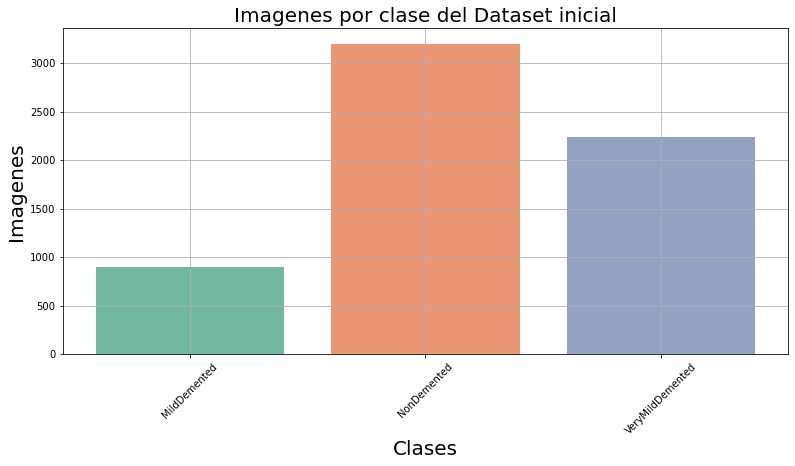

In [3]:
import seaborn as sns
plt.figure(figsize=(13,6))
ax = sns.countplot(x=df.label,palette='Set2')
ax.set_xlabel("Clases",fontsize=20)
ax.set_ylabel("Imagenes",fontsize=20)
plt.title('Imagenes por clase del Dataset inicial',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.plot()

In [9]:
#Necesidad de igualar datos en el dataset


work_dr = ImageDataGenerator(
    rescale = 1./255
    )
train_data_gen = work_dr.flow_from_dataframe(df,x_col='image',y_col='label', target_size=[176,176], batch_size=6000, shuffle=False)
train_data, train_labels = train_data_gen.next()

#sm = SMOTE(random_state=15)
#train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
#train_data = train_data.reshape(-1, 176,176, 3)
X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.3, random_state=15,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=15,shuffle=True,stratify=y_test1)
print('X_train : ' , X_train.shape)
print('X_test : ' , X_test.shape)
print('X_val : ' , X_val.shape)
print('y_train : ' , y_train.shape)
print('y_test : ' , y_test.shape)
print('y_val : ' , y_val.shape)

Found 6336 validated image filenames belonging to 3 classes.
X_train :  (4200, 176, 176, 3)
X_test :  (900, 176, 176, 3)
X_val :  (900, 176, 176, 3)
y_train :  (4200, 3)
y_test :  (900, 3)
y_val :  (900, 3)


[]

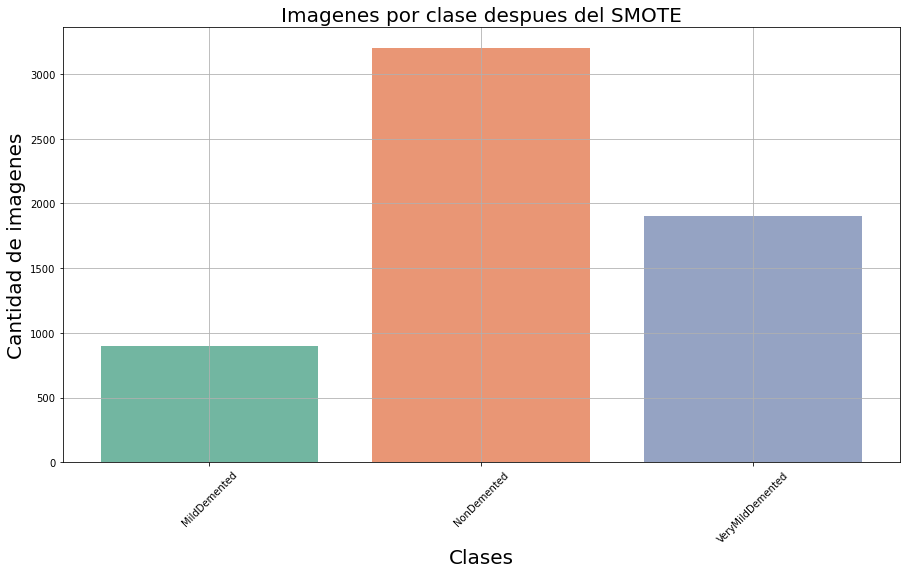

In [5]:
class_num=np.sort(['MildDemented', 'NonDemented', 'VeryMildDemented'])
labels=[class_num[i] for i in np.argmax(train_labels,axis=1) ]
plt.figure(figsize=(15,8))
ax = sns.countplot(x=labels,palette='Set2')
ax.set_xlabel("Clases",fontsize=20)
ax.set_ylabel("Cantidad de imagenes",fontsize=20)
plt.title('Imagenes por clase despues del SMOTE',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.plot()
#plt.savefig('AugmentedData.jpg')

# Modelo

In [11]:

def convolutional_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='selu', padding='same',strides=1),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='selu', padding='same',strides=1),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    return block

In [12]:
def dense_block(u, d_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(u, activation='selu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(d_rate)
    ])
    return block

In [13]:
#Esto me permitira imponer un learningRate dinámico
def exponential_decay(LearningRate,s):
    def exponential_decay_fn(epoch):
        return LearningRate * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 10)

LearningRate= tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
#Con esto el modelo pueede parar antes de tiempo en caso de que ya no mejore
stopping_callback= tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Layer()])  
plt.figure(figsize=(10, 10))

random_sample=np.random.randint(np.random.randint(0,len(X_train)))
im_as_array=X_train[random_sample]* 255
im_as_array = im_as_array.astype(np.uint8)
img=Image.fromarray(im_as_array)
    
augmented_image = data_augmentation(img)
plt.imshow(augmented_image)
plt.axis("off")

In [14]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),        
        convolutional_block(16),
        convolutional_block(32),
        convolutional_block(64),
        convolutional_block(128),
        convolutional_block(256),
        tf.keras.layers.Dropout(0.1),
        convolutional_block(512),
        convolutional_block(1024),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        dense_block(1024,0.1),
        dense_block(512,0.1),
        dense_block(256,0.1),
        dense_block(128, 0.1),
        dense_block(64, 0.1),
        dense_block(32, 0.1),
        dense_block(16, 0.1),
        
        tf.keras.layers.Dense(3, activation='softmax')
        
    ])
    model.summary()
    return model

In [32]:
model=build_model()
METRICS = [tf.keras.metrics.AUC(name='AUC'),
           tf.keras.metrics.MeanSquaredError(name='mse')]
model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=0.01),
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS)

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (None, 88, 88, 16)        571       
                                                                 
 sequential_16 (Sequential)  (None, 44, 44, 32)        2160      
                                                                 
 sequential_17 (Sequential)  (None, 22, 22, 64)        7392      
                                                                 
 sequential_18 (Sequential)  (None, 11, 11, 128)       27072     
                                                                 
 sequential_19 (Sequential)  (None, 5, 5, 256)         103296    
                                                                 
 dropout_9 (Dropout)         (None, 5, 5, 256)         0         
                                                                 
 sequential_20 (Sequential)  (None, 2, 2, 512)       

In [34]:
history= model.fit(
    X_train,y_train,
    validation_data=(X_val,y_val),
    steps_per_epoch=100,
    callbacks=[stopping_callback, LearningRate],
    epochs=100)

Epoch 1/100
100/100 [==============================] - 313s 3s/step - loss: 0.8868 - AUC: 0.7556 - mse: 0.1783 - val_loss: 1.2216 - val_AUC: 0.3722 - val_mse: 0.2461 - lr: 0.0100
Epoch 2/100
100/100 [==============================] - 172s 2s/step - loss: 0.8513 - AUC: 0.7761 - mse: 0.1711 - val_loss: 2.2530 - val_AUC: 0.6739 - val_mse: 0.2983 - lr: 0.0079
Epoch 3/100
100/100 [==============================] - 166s 2s/step - loss: 0.8343 - AUC: 0.7812 - mse: 0.1686 - val_loss: 4.0007 - val_AUC: 0.6469 - val_mse: 0.3103 - lr: 0.0063
Epoch 4/100
100/100 [==============================] - 182s 2s/step - loss: 0.8243 - AUC: 0.7889 - mse: 0.1663 - val_loss: 0.8555 - val_AUC: 0.7702 - val_mse: 0.1720 - lr: 0.0050
Epoch 5/100
100/100 [==============================] - 174s 2s/step - loss: 0.8145 - AUC: 0.7957 - mse: 0.1643 - val_loss: 2.4145 - val_AUC: 0.7452 - val_mse: 0.3002 - lr: 0.0040
Epoch 6/100
100/100 [==============================] - 176s 2s/step - loss: 0.7918 - AUC: 0.8066 - mse: 0

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['AUC','mse','loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [48]:
model.evaluate(X_test,y_test)

29/29 [==============================] - 9s 302ms/step - loss: 0.2773 - AUC: 0.9807 - mse: 0.0470


[0.2772814929485321, 0.9806919693946838, 0.046986352652311325]

In [3]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def graficar_matriz_de_confusion(y_ref, y_pred, clases, cmap=plt.cm.Blues):

    titulo = 'Matriz de confusión'

    cm = confusion_matrix(y_ref, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=clases, yticklabels=clases,
           title=titulo,
           ylabel='Categoría real',
           xlabel='Predicción')

    # Rotar y alinear ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Rellenar gráfica con los valores de la matriz de confusión
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

28/28 [==============================] - 11s 364ms/step


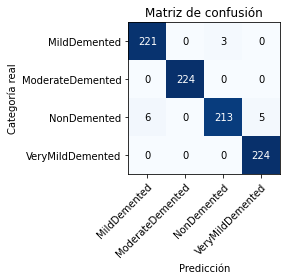

In [21]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_ref = np.argmax(y_test,axis=1)
y=np.argmax(y_pred, axis=1)

graficar_matriz_de_confusion(y_ref, y, class_names)

29/29 [==============================] - 8s 288ms/step


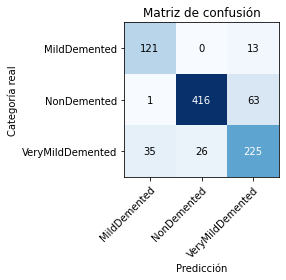

In [47]:
y_pred = (modelo.predict(X_test))
y_ref = np.argmax(y_test,axis=1)
y=np.argmax(y_pred, axis=1)

graficar_matriz_de_confusion(y_ref, y, class_names)

In [49]:
#Guardamos el modelo ya entrenado
model.save('AD_model.h5')


C:\Users\Juan\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Logica de la api(aun por desarrollar)

In [61]:
from PIL import Image, ImageOps
import pandas as pd
def pred_npy(img,modelo):
    class_names = [ 'MildDemented','NonDemented', 'VeryMildDemented']
    x_train=load_img(img)
    lista=modelo.predict(x_train)[0]#Se podria añadir una logica interna en caso de que el modelo no este muy seguro entre opciones
    results=pd.Series(lista).idxmax()
    if(lista[results]>0.8):
        print("The model is very certain of the result :" +class_names[results])
    elif(lista[results]>0.6):
         print("The model is  certain of the result :" +class_names[results])
    else:
         print("The model is not certain of the result :" +class_names[results])

In [59]:
def load_img(img):
    Size=(176,176)  
    images = []
    labels = []
    img.save('img.jpg')
    labels.append( 'None')
    images.append('img.jpg')
    df = pd.DataFrame({'image': images,'label':labels})
    work_dr = ImageDataGenerator(
    rescale = 1./255
    )
    train_data_gen = work_dr.flow_from_dataframe(df,x_col='image', y_col='label',target_size=Size, batch_size=1, shuffle=False)
    train_data,train_labels= train_data_gen.next()
    os.remove('img.jpg')
    return train_data

In [30]:
from keras.models import load_model
modelo = load_model('AD_model.h5')

In [51]:

pred_npy(img,modelo)

NameError: name 'img' is not defined

In [84]:
#Aun queda la parte de crear una api y generar el entorno para devolver la predicción del modelo y cargar la imagen a predecir,
#que seria un front end para poder acceder desde internet

In [88]:
from PIL import Image as im 
from keras.models import load_model
def random_pred():
    #Prediccionaleatoria para comprobar el modelo
    from tqdm import tqdm
    modelo = load_model('AD_model.h5')
    images = []
    labels = []
    for subfolder in tqdm(os.listdir('Alzheimer')):
        subfolder_path = os.path.join('Alzheimer', subfolder)
        for folder in os.listdir(subfolder_path):
            subfolder_path2=os.path.join(subfolder_path,folder)
            for image_filename in os.listdir(subfolder_path2):
                    image_path = os.path.join(subfolder_path2, image_filename)
                    images.append(image_path)
                    labels.append(folder)
    df = pd.DataFrame({'image': images, 'label': labels})
    plt.figure(figsize=(10, 10))
    for i in range(0,9):
        
        random_sample=np.random.randint(np.random.randint(0,len(df)))
        img=cv2.imread(df.image[random_sample])
        img=cv2.resize(img,(400,400))
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(df.label[random_sample])
        sample = im.fromarray(img)
        pred_npy(sample,modelo)
       
    

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 58.82it/s]

Found 1 validated image filenames belonging to 1 classes.


1/1 [==============================] - 1s 594ms/step
The model is very certain of the result :MildDemented
Found 1 validated image filenames belonging to 1 classes.
1/1 [==============================] - 0s 49ms/step
The model is  certain of the result :VeryMildDemented
Found 1 validated image filenames belonging to 1 classes.
1/1 [==============================] - 0s 49ms/step
The model is very certain of the result :NonDemented
Found 1 validated image filenames belonging to 1 classes.
1/1 [==============================] - 0s 51ms/step
The model is very certain of the result :NonDemented
Found 1 validated image filenames belonging to 1 classes.
1/1 [==============================] - 0s 49ms/step
The model is very certain of the result :NonDemented
Found 1 validated image filenames belonging to 1 classes.
1/1 [==============================] - 0s 57ms/step
The model is very certain of the result :VeryMildDemented
Found 1 validated image filenames belonging to 1 classes.
1/1 [=========

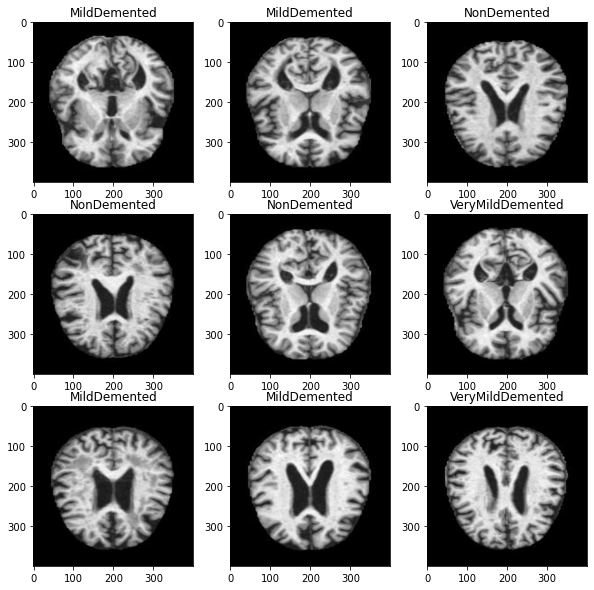

In [89]:
random_pred()

# Data augmentation 

In [17]:
datagen = ImageDataGenerator(
    rotation_range=50,  # Rango de rotación (grados)
    width_shift_range=0.2,  # Rango de desplazamiento horizontal
    height_shift_range=0.2,  # Rango de desplazamiento vertical
    shear_range=0.3,  # Rango de deformación por cizallamiento
    zoom_range=0.3,  # Rango de zoom
    horizontal_flip=True,  # Voltear horizontalmente
    fill_mode='nearest',  # Modo de relleno para recortes
    validation_split=0.2)

<class 'NoneType'>


In [64]:
datagen.fit(X_train)

Text(0.5, 1.0, 'NonDemented')

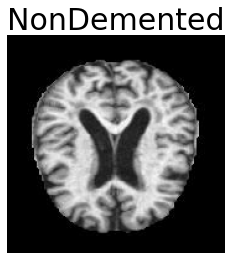

In [63]:
random_sample=np.random.randint(np.random.randint(0,len(X_train)))
im_as_array=X_train[random_sample]* 255
im_as_array = im_as_array.astype(np.uint8)
img=Image.fromarray(im_as_array)
plt.imshow(img)
plt.axis('off')
plt.title(df.label[random_sample],fontsize=30)

NameError: name 'convolutional_block' is not defined